# Open Data Cube - Fractional Cover Notebook

**Description:** This Python notebook allows users to directly interact with an Open Data Cube to calculate Fractional Cover

## Import libraries

In [17]:
%matplotlib inline
import datacube
from datetime import datetime, timedelta
from fc.fractional_cover import fractional_cover
from datacube.storage import masking
import xarray as xr
import pandas as pd
import numpy as np
import gc
from skimage import exposure
import warnings
from matplotlib import pyplot as plt

dc = datacube.Datacube(app='fc-tester-example')

In [2]:
measurements = [
    {'name': 'BS',
     'src_var': 'BS',
     'units': "percent",
     'dtype': 'int8',
     'nodata': -1,
     'zlib': True,
     'fletcher32': True,
     'attrs':{
         'long_name': "Bare ground fraction percentage",
         'comment': "Fraction of bare ground including rock, bare and disturbed soil, within the Landsat pixel as percentages",
         'alias': "bare",
         'coverage_content_type': 'modelResult'
     },
      'aliases':["bare"]},
    {'name': 'PV',
      'src_var': 'PV',
      'units': "percent",
      'dtype': 'int8',
      'nodata': -1,
      'zlib': True,
      'fletcher32': True,
      'attrs':{
          'long_name': "Green cover fraction percentage",
          'comment': "Fraction of green cover including green groundcover and green leaf material over all strata, within the Landsat pixel, as percentages",
          'alias': "green",
          'coverage_content_type': 'modelResult'
          },
      'aliases': ["green_veg"]},
    {'name': 'NPV',
      'src_var': 'NPV',
      'units': "percent",
      'dtype': 'int8',
      'nodata': -1,
      'zlib': True,
      'fletcher32': True,
      'attrs':{
          'long_name': "Non-green cover fraction percentage",
          'comment': "Fraction of non green cover including litter, dead leaf and branches over all strata, within the Landsat pixel, as percentages",
          'alias': "dead",
          'coverage_content_type': 'modelResult'
         },
      'aliases': ["dead_veg"]},
    {'name': 'UE',
      'src_var': 'UE',
      'units': "1",
      'dtype': 'int8',
      'nodata': -1,
      'zlib': True,
      'fletcher32': True,
      'attrs':{
          'long_name': "Unmixing error",
          'comment': "Eclidean Norm of the Residual Vector",
          'alias': "err",
          'coverage_content_type': 'qualityInformation'
          },
      'aliases': ["err"]}
]

# Define functions

In [3]:
def three_band_image(ds, bands=['red', 'green', 'blue'], time=0, figsize=(10, 10), title='Time',
                     projection='projected', contrast_enhance=False, percentile_stretch = [1, 99]):

    """
    This function takes three spectral bands and plots them as the RGB bands of an image.

    Last modified: May 2018
    Author: Mike Barnes
    Modified by: Claire Krause, Cate Kooymans, Robbi Bishop-Taylor


    :param ds:
        An xarray dataset containing the bands to be plotted. For correct axis scales, the xarray
        will ideally have spatial data (e.g. an `.extent` method)

    :param bands:
        Optional list of three bands to be plotted (defaults to `['red', 'green', 'blue']`)

    :param time:
        Optional index value of the time dimension of the xarray dataset to be plotted (defaults to 0)

    :param figsize:
        Optional tuple or list giving the dimensions of the output plot (defaults to `(10, 10)`)

    :param title:
        Optional string for the plot title. If left as the default 'Time', the title will be taken from
        the timestep of the plotted image if available

    :param projection:
        Determines if the image is in degrees or northings (options are 'projected' or 'geographic')

    :param contrast_enhance:
        Optionally transform data using a histogram stretch. If `contrast_enhance = True`,
        exposure.equalize_hist is used to transform the data. Else, the data are standardised relative
        to a default reflectance = 5000 (this can be customised using `reflect_stand`)

    :param percentile_stretch:
        Optionally allows you to have greater control over the contrast stretch by manually specifying 
        min and max percentiles used to stretch the image colours. Defaults to [1, 99], which produces 
        a vibrant image without extreme contrast sometimes produced using `contrast_enhance=True`. To
        plot the image as-is without any stretch, use `percentile_stretch=[0, 100].


    :return fig:
        A matplotlib figure object for customised plotting

    :return ax:
        A matplotlib axis object for customised plotting


    :example:
        >>> # Import external functions from dea-notebooks
        >>> sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts'))
        >>> import DEAPlotting
        >>>
        >>> # Load Landsat time series
        >>> xarray_dataset = dc.load(product='ls8_nbart_albers', **query)
        >>>
        >>> # Plot as an RGB image
        >>> DEAPlotting.three_band_image(ds=xarray_dataset)

    """

    # Use different approaches to data prep depending on whether dataset has temporal dimension
    try:

        # Create new numpy array matching shape of xarray
        t, y, x = ds[bands[0]].shape
        rawimg = np.zeros((y, x, 3), dtype=np.float32)

        # Add xarray bands for a given time into three dimensional numpy array
        for i, colour in enumerate(bands):

            rawimg[:, :, i] = ds[colour][time].values
            
    except ValueError:

        # Create new numpy array matching shape of xarray
        y, x = ds[bands[0]].shape
        rawimg = np.zeros((y, x, 3), dtype=np.float32)

        # Add xarray bands into three dimensional numpy array
        for i, colour in enumerate(bands):

            rawimg[:, :, i] = ds[colour].values
            
    # Set nodata value to NaN
    rawimg[rawimg == -999] = np.nan

    # Optionally compute contrast based on histogram
    if contrast_enhance:

        # Stretch contrast using histogram
        # img_toshow = exposure.equalize_hist(rawimg, mask=np.isfinite(rawimg))
        p2, p98 = np.percentile(rawimg, (2, 98))
        img_toshow = exposure.rescale_intensity(rawimg, in_range=(p2, p98))
        
    else:

        # Stretch contrast using defined reflectance standardisation and clip to between 0 and 1
        # to prevent warnings; defaults to reflect_stand = 5000
        p2, p98 = np.percentile(rawimg, percentile_stretch)
        img_toshow = exposure.rescale_intensity(rawimg, in_range=(p2, p98))
        # img_toshow = (rawimg / reflect_stand).clip(0, 1)

    # Plot figure, setting x and y axes from extent of xarray dataset
    fig, ax = plt.subplots(figsize=figsize)

    try:

        # Plot with correct coords by setting extent if dataset has spatial data (e.g. an `.extent` method).
        # This also allows the resulting image to be overlaid with other spatial data (e.g. a polygon or point)
        left, bottom, right, top = ds.extent.boundingbox
        plt.imshow(img_toshow, extent=[left, right, bottom, top])

    except:

        # Plot without coords if dataset has no spatial data (e.g. an `.extent` method)
        print("xarray dataset has no spatial data; defaulting to plotting without coordinates. "
              "This can often be resolved by adding `keep_attrs = True` during an aggregation step")
        plt.imshow(img_toshow)

    # Set title by either time or defined title
    if title == 'Time':

        try:

            # Plot title using timestep
            ax.set_title(str(ds.time[time].values), fontweight='bold', fontsize=14)

        except:

            # No title
            ax.set_title('', fontweight='bold', fontsize=14)

    else:

        # Manually defined title
        ax.set_title(title, fontweight='bold', fontsize=14)

    # Set x and y axis titles depending on projection
    if projection == 'geographic':

        ax.set_xlabel('Longitude', fontweight='bold')
        ax.set_ylabel('Latitude', fontweight='bold')
        
    else:

        ax.set_xlabel('Eastings', fontweight='bold')
        ax.set_ylabel('Northings', fontweight='bold')
        
    return fig, ax

## Calculate FC

## Retrieving Surface reflectance, Cloud Filtering and Cloud Masking

In [4]:
def load_combine_mask_discard(sensors, bands_of_interest, query, cloud_free_threshold):  
    sensor_clean = {}
    for sensor in sensors: #loop through specified sensors
        sensor_sr = dc.load(product= sensor+'_usgs_sr_scene',
                               measurements = bands_of_interest,group_by='solar_day', 
                               **query) 
        
        # if no data found for sensor skip it
        if not sensor_sr.data_vars:
            print('skipping %s' % sensor) 
            continue
        
        #retrieve the projection information before masking/sorting so we can add it back later
        crs = sensor_sr.crs
        affine = sensor_sr.affine
        
        # Convert No-Data values to NaNs
        sensor_sr = masking.mask_invalid_data(sensor_sr)      
        
        #assign masked data to array
        sensor_clean[sensor] = sensor_sr

        print('loaded %s' % sensor) 
    
    #combine sensors and sort by time
    sr_clean = xr.concat(sensor_clean.values(), 'time')
    del sensor_clean
    sr_clean = sr_clean.sortby('time')
        
    
    #apply projection information to resulting xarray
    sr_clean.attrs['crs'] = crs
    sr_clean.attrs['affine'] = affine
    return sr_clean

# Query and extract data from Data Cube

In [5]:
#Some example areas of interest
lacantan_bounds = {
    'x': (-91.1621, -91.0011),
    'y': (15.9977, 16.1652)
}

sisal_bounds = {
    'x': (-90.0688, -89.9758),
    'y': (21.1057, 21.1975)
}

lake_cuitzeo_bounds = {
    'x': (-101.3879, -101.1072),
    'y': (19.7894, 20.0734)
}

grande_de_santiago_river_bounds = {
    'x': (-105.4834, -105.3600),
    'y': (21.5759, 21.7016)
}


In [6]:
# Lets look at the grande de santiago river
aoi_bounds = grande_de_santiago_river_bounds

In [7]:
#Query is created
query = {'time': ('2017-12-01', '2017-12-12'),}
query['x'] = aoi_bounds['x']
query['y'] = aoi_bounds['y']
query['crs'] = 'EPSG:4326'
query['resolution'] = (-30, 30)
query['output_crs'] = 'EPSG:32616'

#The bands required for FC
bands_of_interest = ['blue','green','red','nir','swir1','swir2','pixel_qa']

#define Landsat sensors of interest
sensors = ['ls8','ls7','ls5'] 

In [8]:
#Load clean surface reflectance data from Data Cube
sr_clean = load_combine_mask_discard(sensors, bands_of_interest, query, cloud_free_threshold)

loaded ls8
skipping ls7
skipping ls5


In [9]:
single_sr = sr_clean.isel(time=0)

In [11]:
warnings.filterwarnings('ignore') #turn off warnings
fc = fractional_cover(single_sr,measurements) #use function
warnings.filterwarnings('always') #turn on warnings

## Plot FC

In [13]:
fc = fc.rename({'BS':'red','PV':'green','NPV':'blue'})

(<matplotlib.figure.Figure at 0x7f827731cd68>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f828ce8b0b8>)

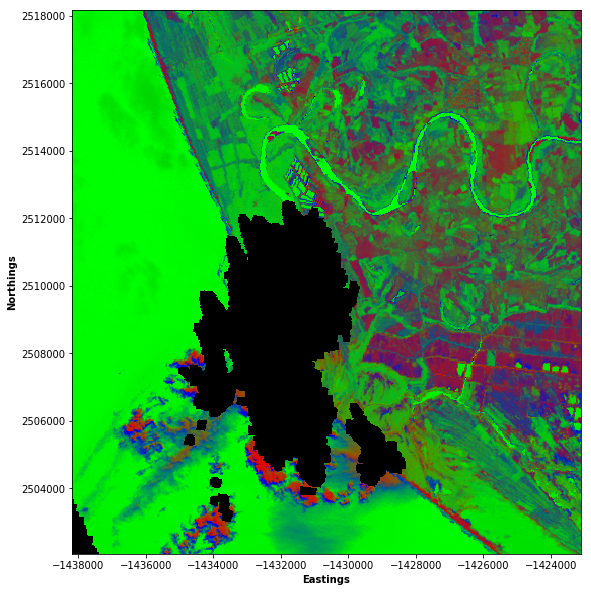

In [14]:
three_band_image(fc)